In [374]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from ADM import ADM
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import normalize

from data_loader import load_pickle, unpack_data
from mutual_information import (
    compute_mutual_information,
    create_spectrogram,
    to_spikes_and_back,
    first_order_low_pass
)
sns.set()

SUBJECT_IDX = 8

In [293]:
dataset = load_pickle(SUBJECT_IDX)

### Create spectrogram of PPG signal

<ipython-input-453-279a0b9fad8e>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


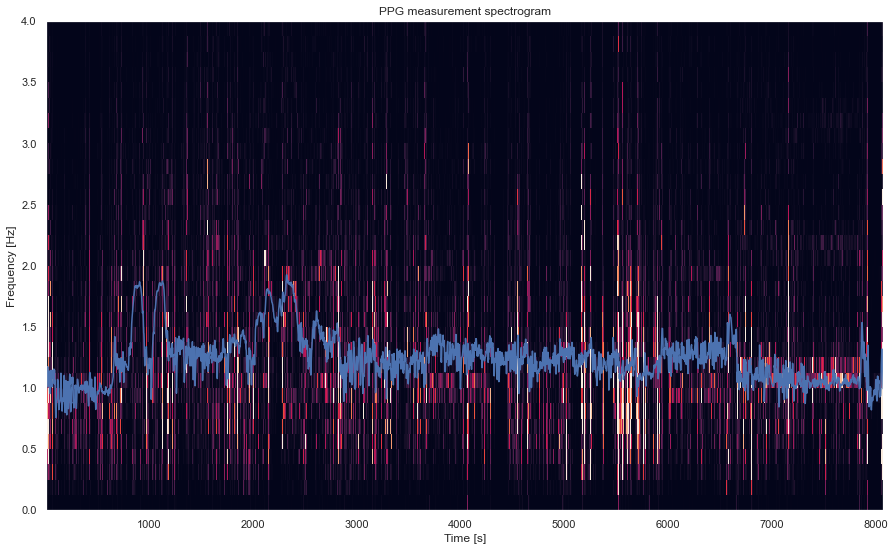

In [453]:
fs_ppg = 64
nperseg_ppg = 8 * 64
noverlap = 6 * 64
fmin = 0 # Hz
fmax = 4 # Hz

ppg, acc, hr, activity, _= unpack_data(dataset)

hr_timestamps = np.arange(4, len(hr) * 2 + 4, 2)
hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

### create spectrogram
f_ppg, t_ppg, Sxx_ppg = create_spectrogram(ppg, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_ppg)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')


plt.plot(t_ppg, hr_at_ppg_timestamps)

### Run PPG through ADM

In [541]:
ADM_factor = 0.01
ADM_step_size = ADM_factor * np.mean(abs(ppg))
up_spikes, down_spikes = ADM(
    ppg,
    up_threshold=ADM_step_size,
    down_threshold=ADM_step_size,
    sampling_rate=fs_ppg,
    refractory_period=0
)

In [542]:
print('mean spike rate:', (len(up_spikes) + len(down_spikes)) / len(ppg) * 64)

mean spike rate: 57.92339108910891


### Reconstruct original signal from ADM-generated spike train using gaussian kernel

In [543]:
def exp_decaying_filter(tau):
    return np.exp(-np.arange(0, tau * 5, 1 / 64) / tau) / tau

In [544]:
def reconstruct_from_spikes(spikes, length, spike_value, use_exponential=False, tau=0.1):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    
    if use_exponential:
        reconstructed_signal = signal.convolve(reconstructed_signal, exp_decaying_filter(tau), mode='full')[:length]
    else:
        reconstructed_signal = gaussian_filter1d(reconstructed_signal, 10)
    return reconstructed_signal

In [545]:
high_tau = 0.35
low_tau = 0.3

reconstructed_signal = (
    reconstruct_from_spikes(up_spikes, len(ppg), 1, tau=low_tau) +
    reconstruct_from_spikes(down_spikes, len(ppg), -1, tau=low_tau) #+
    #reconstruct_from_spikes(up_spikes, len(ppg), -1, tau=high_tau) +
    #reconstruct_from_spikes(down_spikes, len(ppg), 1, tau=high_tau)
)

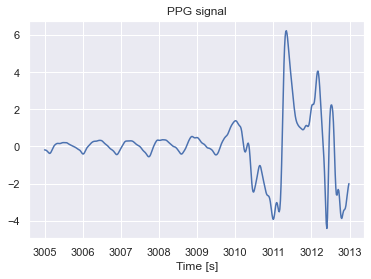

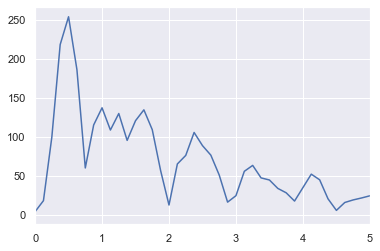

In [637]:
plot_segment_start_seconds = 3005
plot_segment_start = plot_segment_start_seconds * 64
plot_segment_length = 512
plot_fft = True

time_segment = np.arange(plot_segment_start, plot_segment_start+plot_segment_length, 1) / 64
ppg_segment = ppg[plot_segment_start:plot_segment_start+plot_segment_length]
ppg_segment = ppg_segment / np.mean(abs(ppg_segment))
plt.plot(time_segment, ppg_segment)
plt.xlabel('Time [s]')
plt.title('PPG signal')
plt.show()

if plot_fft:
    ppg_spectrum = abs(fft(ppg_segment)[:len(ppg_segment)//2])
    freqs = fftfreq(len(ppg_segment), 1 / 64)[:len(ppg_segment)//2]
    plt.plot(freqs, ppg_spectrum)
    plt.xlim(0, 5)

In [638]:
hr_interpolation(plot_segment_start_seconds)

array(1.16152986)

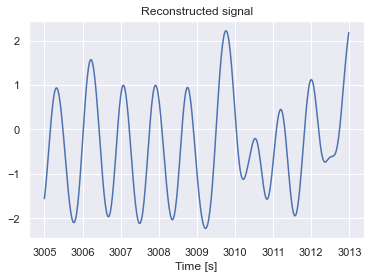

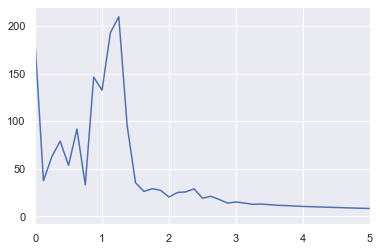

In [639]:
rec_segment = reconstructed_signal[plot_segment_start:plot_segment_start+plot_segment_length]
rec_segment = rec_segment / np.mean(abs(rec_segment))
plt.plot(time_segment, rec_segment)
plt.xlabel('Time [s]')
plt.title('Reconstructed signal')
plt.show()

if plot_fft:
    rec_spectrum = abs(fft(rec_segment)[:len(rec_segment)//2])
    freqs = fftfreq(len(rec_segment), 1 / 64)[:len(rec_segment)//2]
    plt.plot(freqs, rec_spectrum)
    plt.xlim(0, 5)

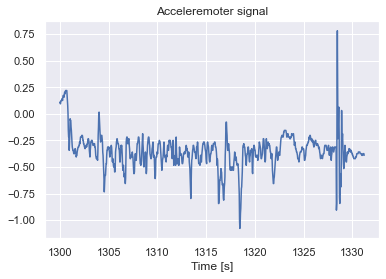

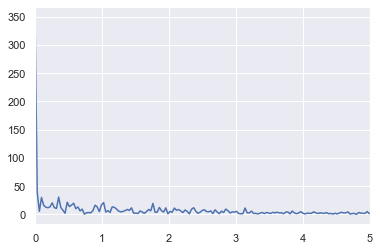

In [621]:
acc_segment = acc[plot_segment_start // 2:(plot_segment_start+plot_segment_length) // 2]
plt.plot(time_segment[::2], acc_segment)
plt.xlabel('Time [s]')
plt.title('Acceleremoter signal')
plt.show()

if plot_fft:
    acc_spectrum = abs(fft(acc_segment)[:len(acc_segment)//2])
    freqs = fftfreq(len(acc_segment), 1 / 32)[:len(acc_segment)//2]
    plt.plot(freqs, acc_spectrum)
    plt.xlim(0, 5)

### Create spectrogram of reconstructed signal

<ipython-input-388-60e36cf43055>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')


Text(0.5, 0, 'Time [s]')

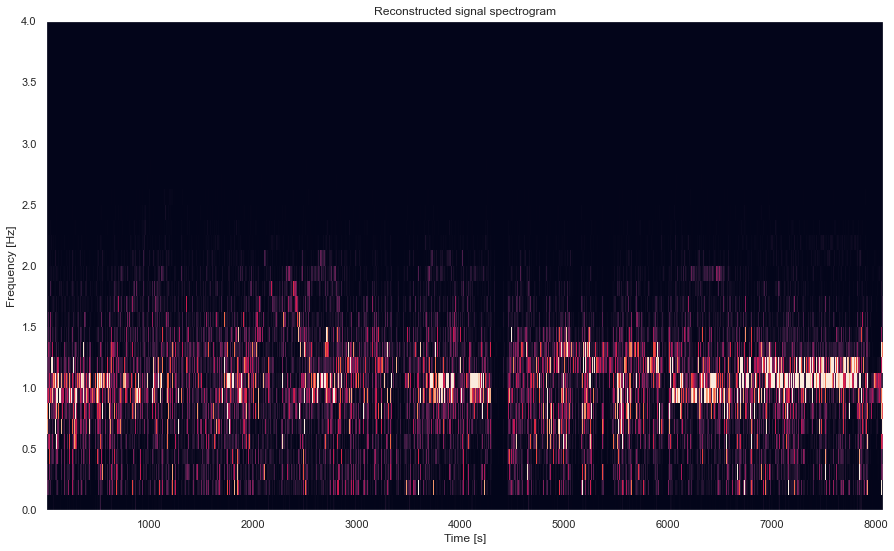

In [388]:
### create spectrogram
f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

### interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_rec)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')
plt.title('Reconstructed signal spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

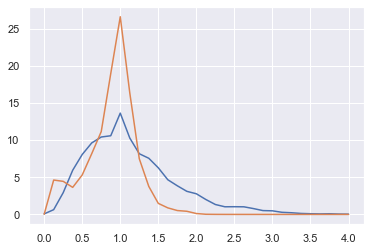

In [436]:
plt.plot(f_ppg, np.var(Sxx_ppg, axis=1))
plt.plot(f_rec, np.var(Sxx_rec, axis=1))

### Mutual information

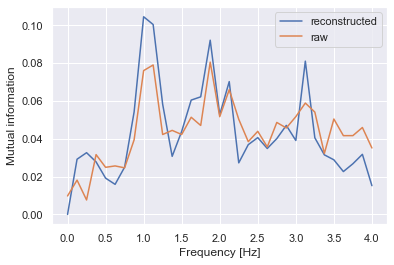

In [397]:
n_neighbors = 10
num_hr_bins = 15
num_power_bins = 6
Sxx_ppg_normalized = normalize(Sxx_ppg, axis=0)
Sxx_rec_normalized = normalize(Sxx_rec, axis=0)
mutual_info_rec = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_rec_sklearn = mutual_info_regression(np.transpose(Sxx_rec), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
mutual_info_ppg = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_ppg_sklearn = mutual_info_regression(np.transpose(Sxx_ppg), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
#plt.plot(f_ppg, mutual_info_ppg, label='ppg')
#plt.plot(f_rec, mutual_info_rec, label='rec')
plt.plot(f_rec, mutual_info_rec_sklearn, label='reconstructed')
plt.plot(f_ppg, mutual_info_ppg_sklearn, label='raw')
plt.ylabel('Mutual information')
plt.xlabel('Frequency [Hz]')
plt.legend()